In [1]:
# for rendering Latex

import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

# Using seaborn's style
#plt.style.use('science')
#plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-dark-palette')
#plt.style.use('seaborn-deep')


width = 345

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

/var/folders/v1/1r3cbng93gg6xsx3ghwzpk9c0000gn/T/ipykernel_81046/3664393869.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


In [2]:
# imports
import numpy as np
import os

import sys
sys.path.append('../')

from src.utils import load_data

DATA_DIR = '../data'
BETA_VALUES = np.sort(
    [float(x.split('fermi_')[-1]) for x in os.listdir(DATA_DIR) if x.startswith('fermi')])

print('Beta values:',len(BETA_VALUES))

Beta values: 30


(1200000, 64) (120000, 64) (6000, 64)


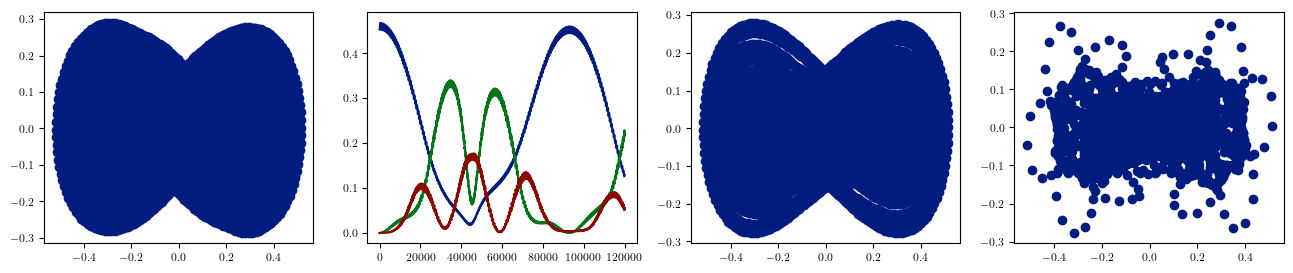

In [3]:
# load and visuliase data
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3))

beta = 1.6
data = load_data(DATA_DIR, beta)
X = data.data_matrix

q, p = X[:, 0], X[:, 32]

ax1.scatter(q, p)
n_portion = 120000

ax2.plot(data.energy_matrix[:,0][:n_portion], linewidth=1.5, label="Mode 1") 
ax2.plot(data.energy_matrix[:,2][:n_portion], linewidth=1.5, label="Mode 1")
ax2.plot(data.energy_matrix[:,4][:n_portion], linewidth=1.5, label="Mode 1")

# take portion of data

X_portion = X[:n_portion]
q_portion, p_portion = X_portion[:, 0], X_portion[:, 32]

ax3.scatter(q_portion, p_portion)

# subsample data

X_subsample = X_portion[0::20]
q_subsample, p_subsample = X_subsample[:, 0], X_subsample[:, 32]

ax4.scatter(q_subsample, p_subsample)

print(X.shape, X_portion.shape, X_subsample.shape)

In [4]:
def temporalize_data(X, timesteps):
    output_X = []
    for i in range(len(X)-timesteps-1):
        t = []
        for j in range(1, timesteps+1):
            # Gather past records upto the timesteps period
            t.append(X[(i+j+1), :])
        output_X.append(t)
    return np.array(output_X)

In [5]:
# temporalise data for. LSTM needs data to be of dim 3, being <sample size, time, num features>

timesteps = 5
X = temporalize_data(X_portion, timesteps)
X.shape

(119994, 5, 64)

In [6]:
# train LSTM autoencoder 

from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras import regularizers


def autoencoder_model(timesteps, n_features=64):
    sequential = Sequential()
    sequential.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
    # sequential.add(LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=regularizers.L1(10e-))) 
    sequential.add(LSTM(16, activation='relu', return_sequences=False))
    sequential.add(RepeatVector(timesteps))
    sequential.add(LSTM(16, activation='relu', return_sequences=True))
    sequential.add(LSTM(32, activation='relu', return_sequences=True))
    sequential.add(TimeDistributed(Dense(n_features)))
    sequential.compile(optimizer='adam', loss='mse')
    return sequential



In [7]:

model = autoencoder_model(timesteps)
# model.summary()

model.fit(X, X, epochs=50, batch_size=64, verbose=True)

Epoch 1/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0198
Epoch 2/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0014
Epoch 3/50
1065/1875 [================>.............] - ETA: 3s - loss: 7.0902e-04

6250/6250 [==============================] - 3s 503us/step


Text(0.5, 1.0, 'Diffusion map. beta=1.6')

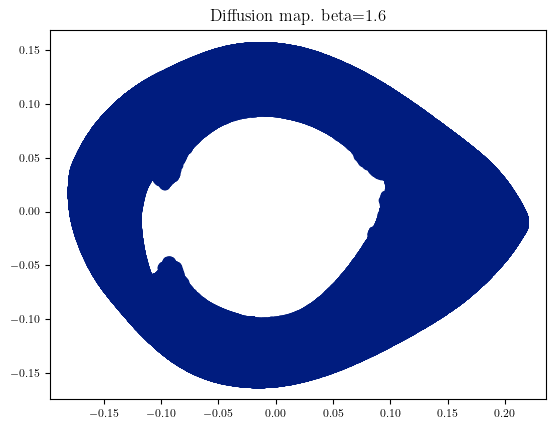

In [81]:
# compute diffusion map 

from keras.models import Model
from pydiffmap import diffusion_map as dm


encoder_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
X_enc = encoder_model.predict(X)

neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}
dmap = dm.DiffusionMap.from_sklearn(
    n_evecs=2,
    k=70,
    epsilon=1.0,
    alpha=1.0,
    neighbor_params=neighbor_params)

X_dm = dmap.fit_transform(X_enc)

plt.scatter(X_dm[:, 0], X_dm[:, 1])
plt.title(f'Diffusion map. beta={beta}')

## Diffusion map Vs beta 

Here I generate diffusion maps on the embedded (encoded) space. <br>

I first train an autoencoder on the trajectory data. The autoencoder is a model that compresses the input data to a low-dimensional hidden layer and decompresses the layer to an output space with the same dimension as the input space. In the decompression process, only the subspace of the input space around the data manifold is recovered because of the DNN property.
The trained autoencoder is composed by encoder and decoder.
After training the autoencoder, I take only the encoder, which compresses the input trajectory data to a low-dimensional space clsoe the data manifold. Finally I perform diffusion map on this lower dimensional space.

Epoch 1/50
1875/1875 [==============================] - 10s 4ms/step - loss: 0.0213
Epoch 2/50
1875/1875 [==============================] - 7s 4ms/step - loss: 1.7932e-04
Epoch 3/50
1875/1875 [==============================] - 7s 4ms/step - loss: 1.1209e-04
Epoch 4/50
1875/1875 [==============================] - 6s 3ms/step - loss: 5.4668e-05
Epoch 5/50
1875/1875 [==============================] - 6s 3ms/step - loss: 4.6618e-05
Epoch 6/50
1875/1875 [==============================] - 6s 3ms/step - loss: 4.1541e-05
Epoch 7/50
1875/1875 [==============================] - 7s 3ms/step - loss: 3.5492e-05
Epoch 8/50
1875/1875 [==============================] - 6s 3ms/step - loss: 4.1631e-05
Epoch 9/50
1875/1875 [==============================] - 6s 3ms/step - loss: 2.3548e-05
Epoch 10/50
1875/1875 [==============================] - 6s 3ms/step - loss: 2.5998e-05
Epoch 11/50
1875/1875 [==============================] - 6s 3ms/step - loss: 2.1250e-05
Epoch 12/50
1875/1875 [=====================

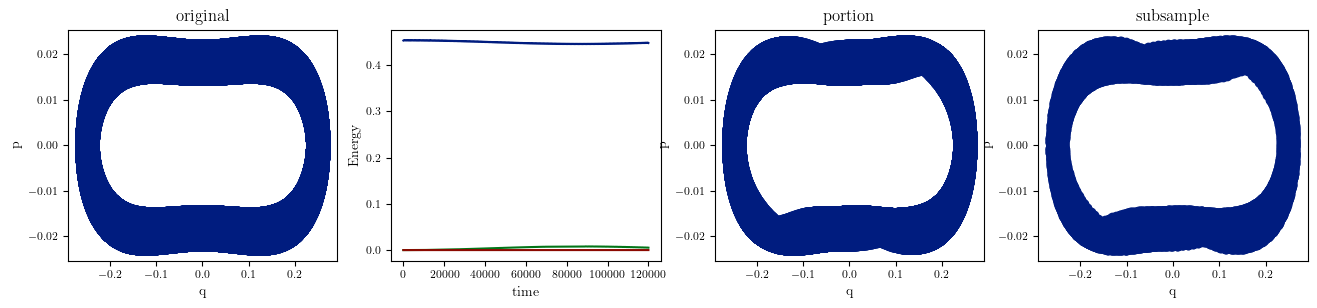

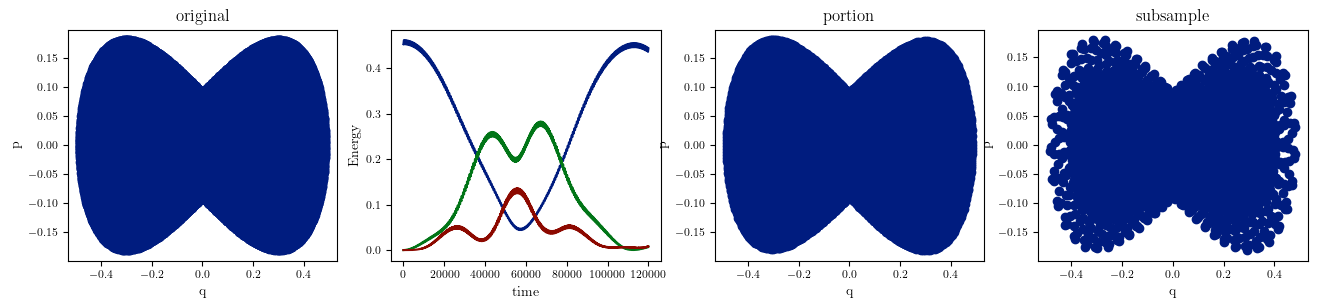

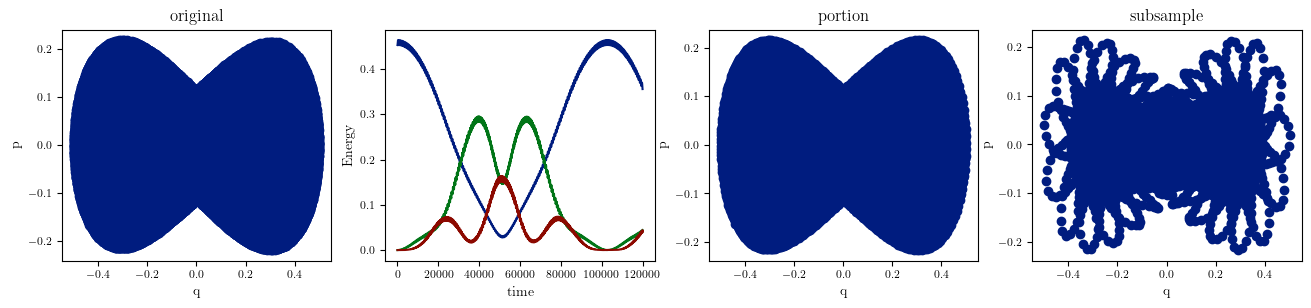

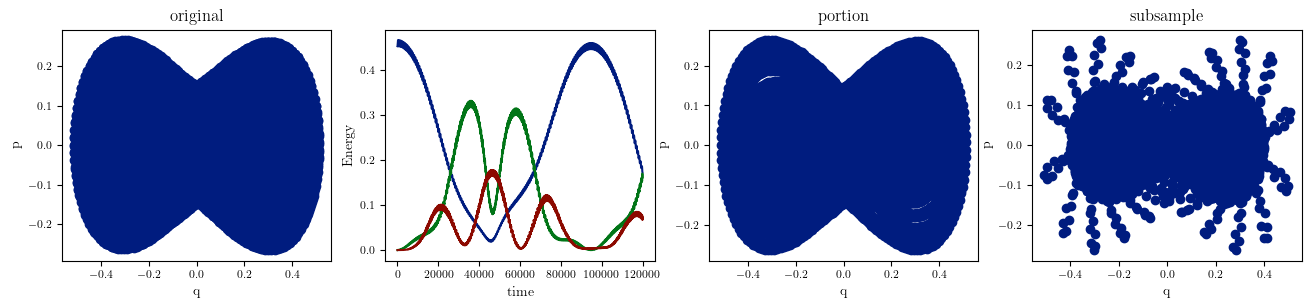

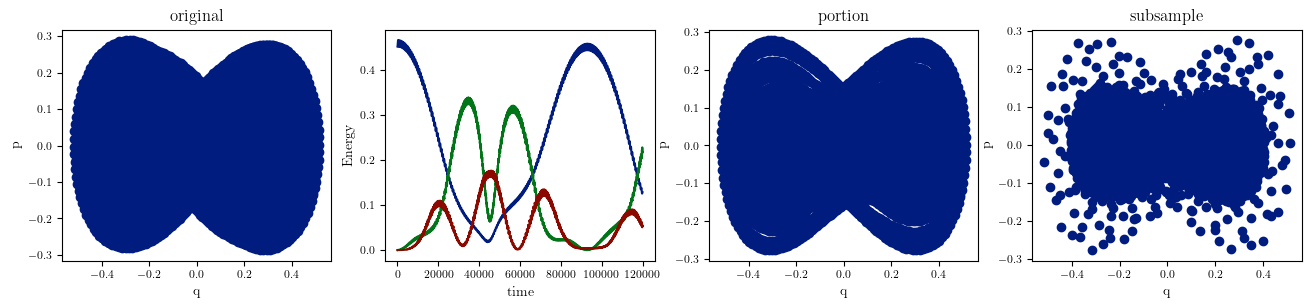

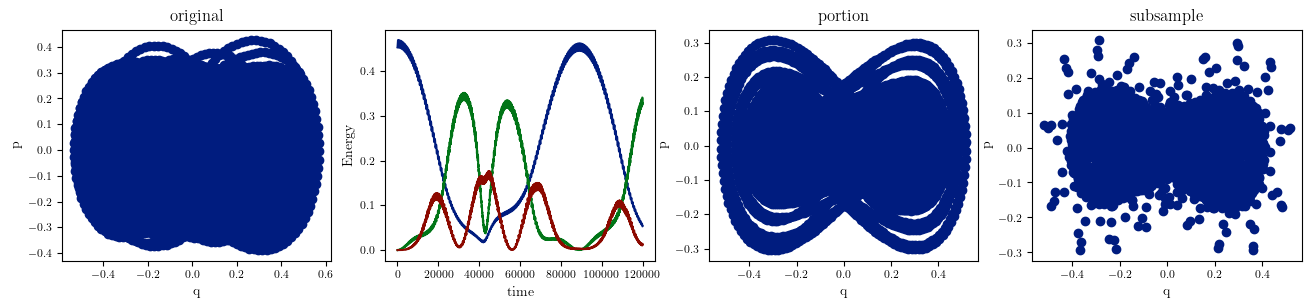

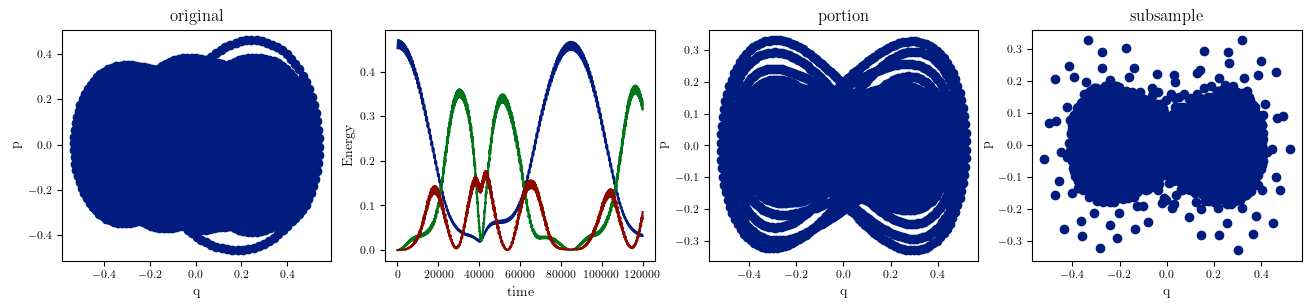

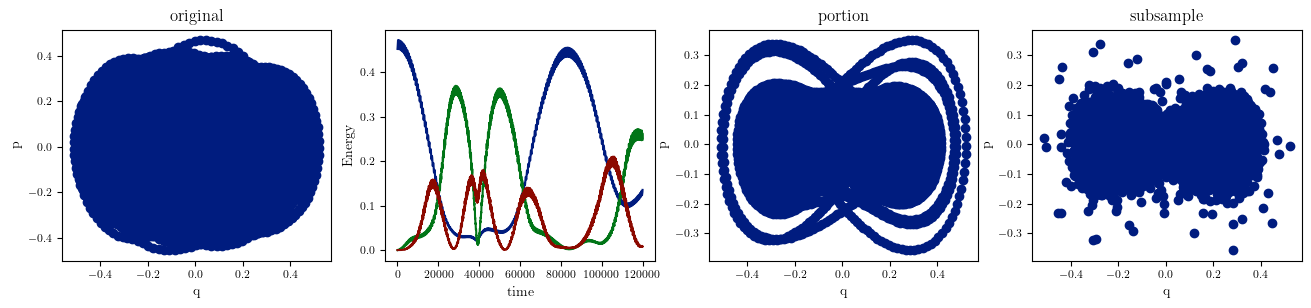

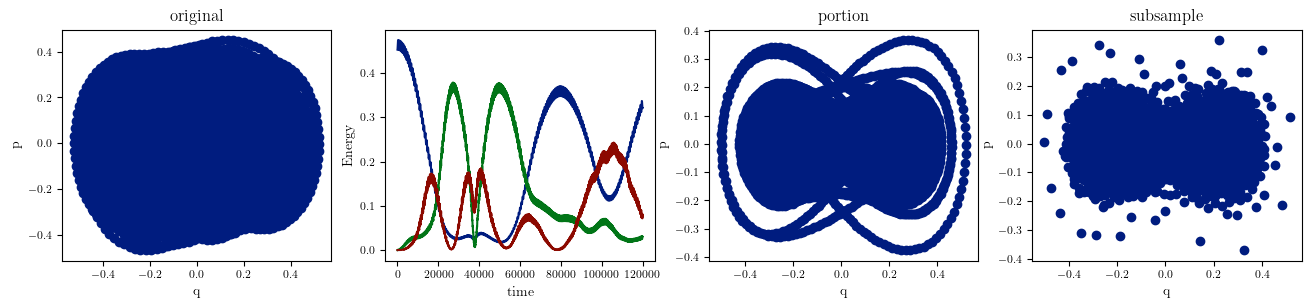

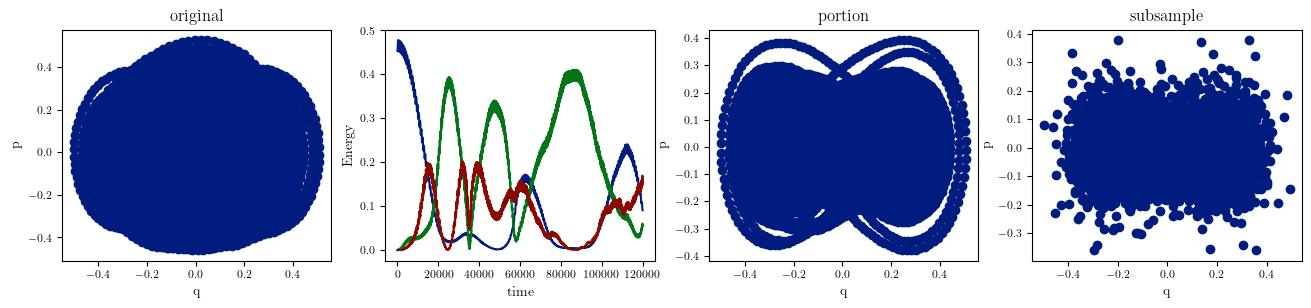

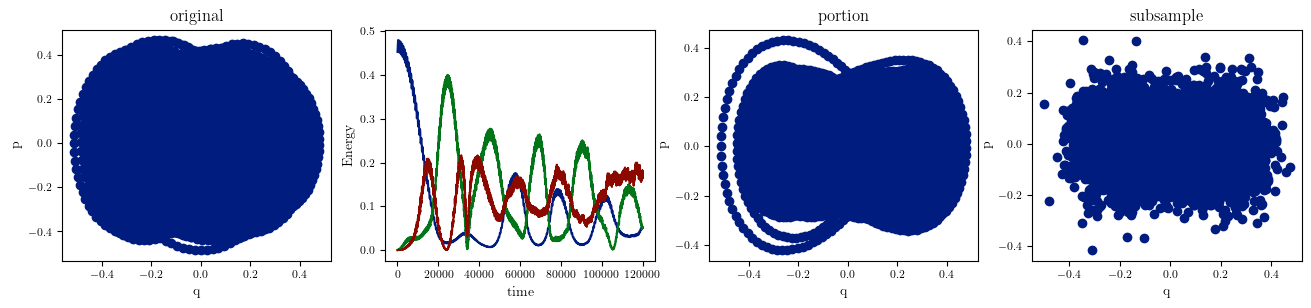

In [69]:
from keras.models import Model
from pydiffmap import diffusion_map as dm


X_dm = {}
for beta in [0.1, 1.0, 1.2, 1.5, 1.6, 1.8, 2.0, 2.2, 2.4, 2.8, 3.0]:

    data = load_data(DATA_DIR, beta)
    X_portion = data.data_matrix[:120000] 
       
    X = temporalize_data(X_portion, 5)
    
    model = autoencoder_model(timesteps)
    model.fit(X, X, epochs=50, batch_size=64, verbose=True)

    encoder_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
    X_enc = encoder_model.predict(X)

    neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}
    dmap = dm.DiffusionMap.from_sklearn(
        n_evecs=2,
        k=50,
        epsilon=1.0,
        alpha=1.0,
        neighbor_params=neighbor_params)

    X_dm[beta] = dmap.fit_transform(X_enc)


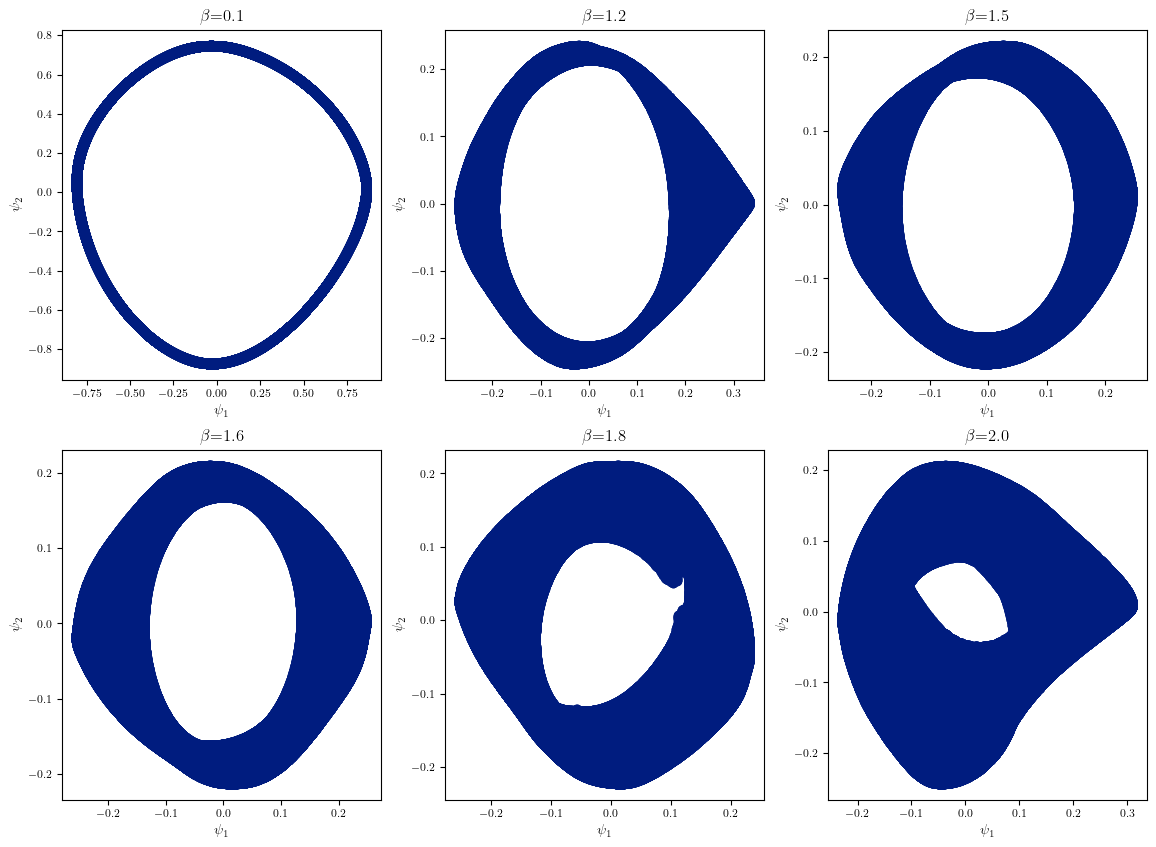

In [71]:
# 'Embedding given by first two DCs'

fig, axs = plt.subplots(2, 3, figsize=(14, 10))

beta = 0.1
axs[0][0].scatter(X_dm[beta][:, 0], X_dm[beta][:, 1])
axs[0][0].set_xlabel(r'$\psi_1$')
axs[0][0].set_ylabel(r'$\psi_2$')
axs[0][0].set_title(rf'$\beta$={beta}')

beta = 1.2
axs[0][1].scatter(X_dm[beta][:, 0], X_dm[beta][:, 1])
axs[0][1].set_xlabel(r'$\psi_1$')
axs[0][1].set_ylabel(r'$\psi_2$')
axs[0][1].set_title(rf'$\beta$={beta}')

beta = 1.5
axs[0][2].scatter(X_dm[beta][:, 0], X_dm[beta][:, 1])
axs[0][2].set_xlabel(r'$\psi_1$')
axs[0][2].set_ylabel(r'$\psi_2$')
axs[0][2].set_title(rf'$\beta$={beta}')

beta = 1.6
axs[1][0].scatter(X_dm[beta][:, 0], X_dm[beta][:, 1])
axs[1][0].set_xlabel(r'$\psi_1$')
axs[1][0].set_ylabel(r'$\psi_2$')
axs[1][0].set_title(rf'$\beta$={beta}')

beta = 1.8
axs[1][1].scatter(X_dm[beta][:, 0], X_dm[beta][:, 1])
axs[1][1].set_xlabel(r'$\psi_1$')
axs[1][1].set_ylabel(r'$\psi_2$')
axs[1][1].set_title(rf'$\beta$={beta}')

beta = 2.0
axs[1][2].scatter(X_dm[beta][:, 0], X_dm[beta][:, 1])
axs[1][2].set_xlabel(r'$\psi_1$')
axs[1][2].set_ylabel(r'$\psi_2$')
axs[1][2].set_title(rf'$\beta$={beta}')

# plt.suptitle('Diffusion map')

plt.savefig("output/diffusion_map_betas_autoencoder.png", dpi=400)

## Transition to equipartition

In [7]:
# train on first portion, when no equipartition

data_train = load_data(DATA_DIR, 1.6)
X_train_portion = data_train.data_matrix[:120000] 
X_train = temporalize_data(X_train_portion, 5)

model = autoencoder_model(timesteps)
model.fit(X_train, X_train, epochs=50, batch_size=64, verbose=True)

Epoch 1/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0212
Epoch 2/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0013
Epoch 3/50
1875/1875 [==============================] - 7s 4ms/step - loss: 7.3958e-04
Epoch 4/50
1875/1875 [==============================] - 7s 4ms/step - loss: 5.3056e-04
Epoch 5/50
1875/1875 [==============================] - 7s 4ms/step - loss: 4.1872e-04
Epoch 6/50
1875/1875 [==============================] - 7s 4ms/step - loss: 3.6616e-04
Epoch 7/50
1875/1875 [==============================] - 7s 4ms/step - loss: 3.2751e-04
Epoch 8/50
1875/1875 [==============================] - 7s 4ms/step - loss: 2.8969e-04
Epoch 9/50
1875/1875 [==============================] - 7s 4ms/step - loss: 2.6225e-04
Epoch 10/50
1875/1875 [==============================] - 7s 4ms/step - loss: 2.3771e-04
Epoch 11/50
1875/1875 [==============================] - 7s 4ms/step - loss: 2.2286e-04
Epoch 12/50
1875/1875 [==========================

In [8]:
# model.save('models/autoencoder.keras')

In [9]:
# use encoder to encode input trajectory data onto low-dimensional space
from keras.models import Model

encoder_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
X_train_enc = encoder_model.predict(X_train)

3750/3750 [==============================] - 2s 512us/step


In [10]:
# compute max reconstruction error on train set (times range within which no equipartition obserrved, so still in the toroid manifold)

X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X), axis=1)

thresholds_train = []
for feature_idx in range(train_mae_loss.shape[1]):
    # feature_threshold = np.mean(train_mae_loss[:,feature_idx]) + np.std(train_mae_loss[:,feature_idx])
    feature_threshold = np.max(train_mae_loss[:, feature_idx])
    thresholds_train.append(feature_threshold)

max_thresholds_train = max(thresholds_train)
np.round(max_thresholds_train, 3), print(np.argmax(thresholds_train))

3750/3750 [==============================] - 4s 877us/step
63


(0.089, None)

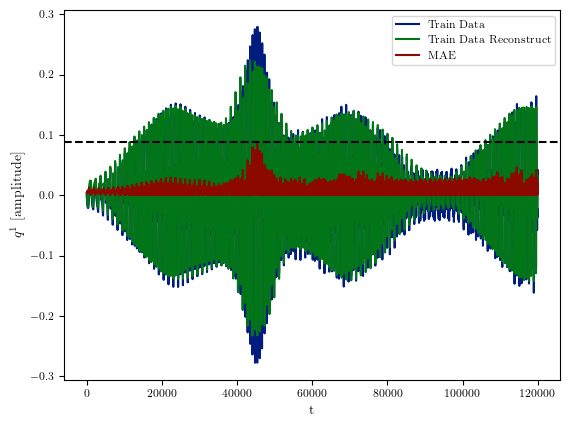

In [11]:
# visualise reconstruction error train. Note I visualise for a specific feature, being the one for which error is max

feature_list = np.arange(1, 66)

feature_idx = 63

limit = 1000000000
plt.figure()

plt.plot(X_train[:limit, 0, feature_idx], label='Train Data')
plt.plot(X_train_pred[:limit,0,feature_idx], label='Train Data Reconstruct')
plt.plot(train_mae_loss[:limit, feature_idx], label='MAE')
plt.axhline(max_thresholds_train, color='k', linestyle='--')

plt.xlabel('t')
plt.ylabel('$q^{1}$ [amplitude]')
plt.legend(loc='upper right')
plt.show()

### find phase transition

In [12]:
# test on remaining portion, where at some point equipartition is observed

data_test = load_data(DATA_DIR, 1.6)
time_test = data_test.time

X_test_portion = data_test.data_matrix[-300000:-1] 
energy_test = data_test.energy_matrix[-300000 +6:-1]  # to account for temporalisation
time_test = time_test[-300000 +6:-1]  # to account for temporalisation

X_test = temporalize_data(X_test_portion, 5)

X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

9375/9375 [==============================] - 8s 795us/step


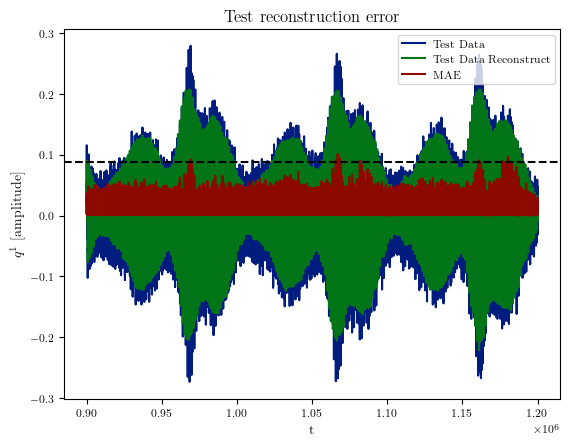

In [15]:
plt.figure()

limit = 2000000

plt.plot(time_test[:limit], X_test[:limit, 0, feature_idx],label='Test Data')
plt.plot(time_test[:limit], X_test_pred[:limit, 0, feature_idx],label='Test Data Reconstruct')
plt.plot(time_test[:limit], test_mae_loss[:limit, feature_idx], label='MAE')
plt.axhline(max_thresholds_train, color='k', linestyle='--')

# test_mae_loss_ = test_mae_loss[:limit, feature_idx]
# mask = test_mae_loss_ > max_thresholds_train 
# test_mae_loss_[mask] -= max_thresholds_train

# plt.plot(time_test[:limit], test_mae_loss_, label='err above threshold')

plt.xlabel('t')
plt.ylabel('$q^{1}$ [amplitude]')
plt.legend(loc='upper right')
plt.title(f'Test reconstruction error')
plt.show()

In [29]:
# find energy portion relative to above threshold reconstruction errror# 

def find_ranges(nums):

    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    ranges  = list(zip(edges, edges))

    # return [range for range in ranges if (range[1] - range[0] > 10)]
    return ranges

times_above_threshold = np.where(test_mae_loss[:limit, feature_idx] > max_thresholds_train)[0] + time_test[0]

ranges = find_ranges(times_above_threshold)

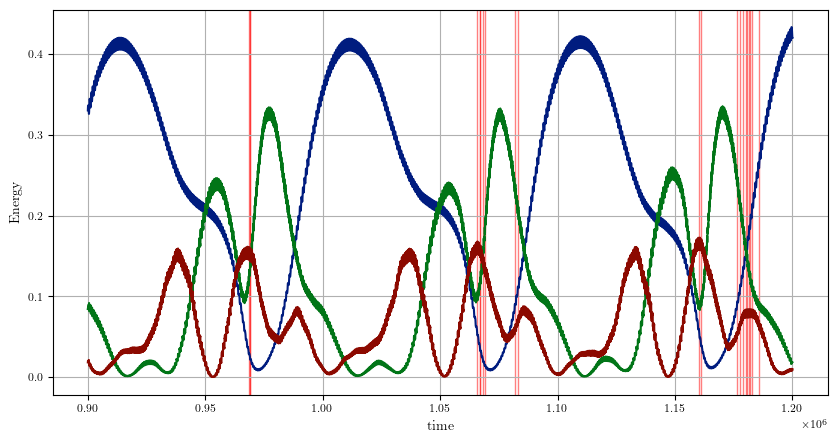

In [155]:
# find energy portion relative to above threshold reconstruction errror

fig, (ax) = plt.subplots(1, 1, figsize=(10,5))
ax.plot(time_test, energy_test[:,0], linewidth=1.5, label="Mode 1") 
ax.plot(time_test, energy_test[:,2], linewidth=1.5, label="Mode 3")
ax.plot(time_test, energy_test[:,4], linewidth=1.5, label="Mode 5")
# ax.scatter(times_above_threshold, [0.0] * len(times_above_threshold), color='red') 

# ax.axvspan(1182784, 1182798, alpha=0.5, color='red')
for range in ranges:
    ax.axvspan(range[0], range[1], alpha=0.5, color='red')

ax.set_xlabel('time')
ax.set_ylabel('Energy')
ax.grid()

In [21]:
# test on data for higher beta

data_test_beta2 = load_data(DATA_DIR, 2.0)
time_test_beta2 = data_test_beta2.time

X_test_beta2_portion = data_test_beta2.data_matrix[:300000] 
energy_test_beta2 = data_test_beta2.energy_matrix[:300000]  # to account for temporalisation
time_test_beta2 = time_test_beta2[:300000]  # to account for temporalisation

X_test_beta2 = temporalize_data(X_test_beta2_portion, 5)

X_test_beta_2_pred = model.predict(X_test_beta2)
test_mae_loss_beta2 = np.mean(np.abs(X_test_beta_2_pred - X_test_beta2), axis=1)

9375/9375 [==============================] - 7s 775us/step


In [23]:
X_test_beta_2_pred.shape, X_test_beta2.shape, time_test_beta2.shape

((299994, 5, 64), (299994, 5, 64), (300000,))

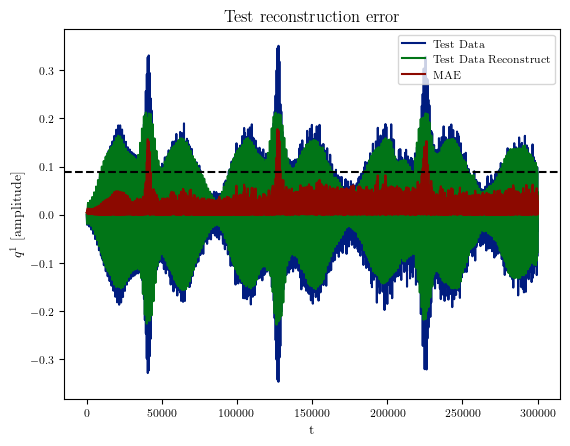

In [25]:
plt.figure()

limit = 2000000

plt.plot(X_test_beta2[:limit, 0, feature_idx],label='Test Data')
plt.plot(X_test_beta_2_pred[:limit, 0, feature_idx],label='Test Data Reconstruct')
plt.plot(test_mae_loss_beta2[:limit, feature_idx], label='MAE')
plt.axhline(max_thresholds_train, color='k', linestyle='--')

plt.xlabel('t')
plt.ylabel('$q^{1}$ [amplitude]')
plt.legend(loc='upper right')
plt.title(f'Test reconstruction error')
plt.show()

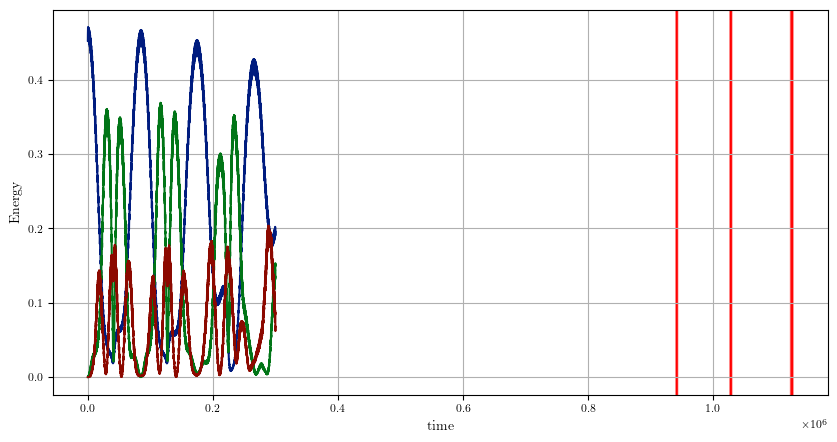

In [32]:
# find energy portion relative to above threshold reconstruction errror

times_above_threshold_beta2 = np.where(
    test_mae_loss_beta2[:limit, feature_idx] > max_thresholds_train)[0] + time_test[0]

ranges = find_ranges(times_above_threshold_beta2)

fig, (ax) = plt.subplots(1, 1, figsize=(10,5))
ax.plot(time_test_beta2, energy_test_beta2[:,0], linewidth=1.5, label="Mode 1") 
ax.plot(time_test_beta2, energy_test_beta2[:,2], linewidth=1.5, label="Mode 3")
ax.plot(time_test_beta2, energy_test_beta2[:,4], linewidth=1.5, label="Mode 5")
# ax.scatter(times_above_threshold_beta2, [0.0] * len(times_above_threshold_beta2), color='red') 

# ax.axvspan(1182784, 1182798, alpha=0.5, color='red')
for range in ranges:
    ax.axvspan(range[0], range[1], alpha=0.5, color='red')

ax.set_xlabel('time')
ax.set_ylabel('Energy')
ax.grid()